##### Key points from the dataset inspection

Dataset Shape and Columns: The dataset has 4388 samples and 16 columns, with the last column "Subject" being the target variable.
- Missing Values: There are a few missing values in columns "Std Dev_X", "Std Dev_Y", and "Std Dev_Mixed" (5 missing values each).
- Features: All columns except "Subject".
- Target: "Subject" with values ranging from 1 to 5.
- Given these details, here are some steps we can take to improve the model:

- Handle Missing Values: Replace missing values or remove rows with missing values.
- Data Normalization: Normalize the input features for better model performance.
- Model Architecture: Adjust the neural network architecture if necessary.
- Train-Test Split: Split the data into training and validation sets to evaluate the model performance more reliably.

Let's implement step by step.

Step 1: Handle Missing Values
We'll fill the missing values with the mean of the respective columns.

Step 2: Normalize the Data
We'll normalize the features to have values between 0 and 1.

Step 3: Split the Data
We'll split the data into training and validation sets (e.g., 80% training, 20% validation).

Step 4: Update the Model
We'll adjust the model architecture if needed and train it using the training set while validating on the validation set.

##### model (model for k-fold cross validation)
This model is used during the K-fold cross-validation process. The purpose of using this model is to evaluate its performance on different splits of the training/validation data to ensure that the model is not `overfitting` and has good generalization performance. Each fold in the K-fold cross-validation involves training a new model from scratch and evaluating it on the validation fold, hence multiple instances of the model are created and trained.

- K-fold Cross-Validation: This technique involves splitting the training data into k folds. For each fold, the model is trained on k-1 folds and validated on the remaining fold. This process is repeated k times, each time with a different validation fold. The average performance across all folds gives an estimate of how the model will perform on unseen data.
- The model created within the cross-validation loop is used to: Train on the training part of the data for that fold. Evaluate on the validation part of the data for that fold. After each fold, the performance metrics (accuracy and loss) are stored for later analysis.

##### final_model (same model for training if the k-fold cross validation exhibits good performance)
After completing the K-fold cross-validation, a final model is trained on the entire training/validation set (X_train_val, y_train_val). This model is intended to leverage all the available data to learn the patterns as effectively as possible. This final model is then evaluated on the separate test set to get an estimate of its performance on truly unseen data.

- Final Training: The final_model is trained using all the training/validation data because K-fold cross-validation has already provided an estimate of model performance and helped to ensure that the model is not overfitting.

##### Following metrics are used for performance evaluation

- Accuracy: This is the primary metric used for evaluating the model's performance in this code. Accuracy is the ratio of correctly predicted instances to the total instances in the dataset. It is calculated both for the training/validation splits during K-fold cross-validation and for the final evaluation on the test set.

- Loss: The loss function used in this code is categorical_crossentropy. Loss measures how well the model's predictions match the true labels. It is calculated during both the training and validation phases within the K-fold cross-validation, and also during the final training and evaluation on the test set.

c:\Users\Eshan\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Fold 1 Validation Accuracy: 78.63%
Fold 2 Validation Accuracy: 79.49%
Fold 3 Validation Accuracy: 77.78%
Fold 4 Validation Accuracy: 79.20%
Fold 5 Validation Accuracy: 80.91%
Fold 6 Validation Accuracy: 77.78%
Fold 7 Validation Accuracy: 79.77%
Fold 8 Validation Accuracy: 82.05%
Fold 9 Validation Accuracy: 77.78%
Fold 10 Validation Accuracy: 78.92%
Mean Validation Accuracy: 79.23% (+/- 1.34%)
Test Set Accuracy: 78.13%
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


<Figure size 1200x600 with 0 Axes>

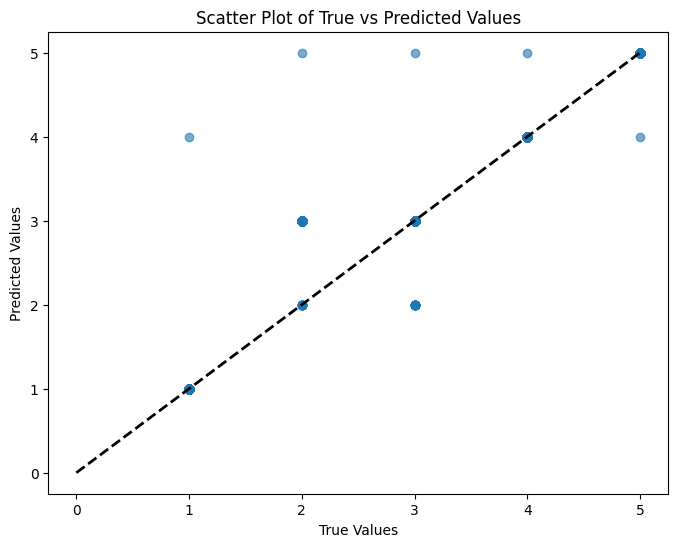

In [7]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import KFold, train_test_split
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Load the dataset
data = pd.read_csv('Dataset/combined_metrics.csv')

# Step 1: Handle missing values by filling with column mean
data.fillna(data.mean(), inplace=True)

# Step 2: Split data into features (X) and target (y)
X = data.drop('category', axis=1).values
y = data['category'].values

# Normalize the features
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# One-hot encode labels
num_classes = 5
y_categorical = to_categorical(y - 1, num_classes)  # Subtract 1 to get labels in range [0, 4]

# Split the data into training/validation and test sets
X_train_val, X_test, y_train_val, y_test = train_test_split(X_scaled, y_categorical, test_size=0.2, random_state=42)

# Define the K-fold Cross Validator
kfold = KFold(n_splits=10, shuffle=True, random_state=42)

# Initialize variables to hold the results
train_accuracies = []
val_accuracies = []
train_losses = []
val_losses = []
history_list = []

# Perform the cross-validation
for fold, (train, val) in enumerate(kfold.split(X_train_val, y_train_val)):
    # Create the model
    model = Sequential([
        Dense(64, input_dim=X_train_val.shape[1], activation='relu'),  # Input layer and first hidden layer
        Dense(128, activation='relu'),  # Second hidden layer
        Dense(64, activation='relu'),  # Third hidden layer
        Dense(num_classes, activation='softmax')  # Output layer
    ])

    # Compile the model
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    # Fit the model and store the history
    history = model.fit(X_train_val[train], y_train_val[train], epochs=100, batch_size=32, 
                        validation_data=(X_train_val[val], y_train_val[val]), verbose=0)
    
    history_list.append(history)
    
    # Evaluate the model
    train_score = model.evaluate(X_train_val[train], y_train_val[train], verbose=0)
    val_score = model.evaluate(X_train_val[val], y_train_val[val], verbose=0)

    # Store accuracy and loss for each fold
    train_accuracies.append(train_score[1] * 100)
    val_accuracies.append(val_score[1] * 100)
    train_losses.append(train_score[0])
    val_losses.append(val_score[0])

    print(f'Fold {fold + 1} Validation Accuracy: {val_score[1] * 100:.2f}%')

# Print the average validation accuracy across all folds
print(f'Mean Validation Accuracy: {np.mean(val_accuracies):.2f}% (+/- {np.std(val_accuracies):.2f}%)')

# Evaluate the final model on the test set
final_model = Sequential([
    Dense(64, input_dim=X_train_val.shape[1], activation='relu'),  # Input layer and first hidden layer
    Dense(128, activation='relu'),  # Second hidden layer
    Dense(64, activation='relu'),  # Third hidden layer
    Dense(num_classes, activation='softmax')  # Output layer
])

final_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
final_model.fit(X_train_val, y_train_val, epochs=100, batch_size=32, verbose=0)
test_scores = final_model.evaluate(X_test, y_test, verbose=0)
print(f'Test Set Accuracy: {test_scores[1] * 100:.2f}%')

# Plot the results for each fold
folds = np.arange(1, 11)
plt.figure(figsize=(12, 6))

# Predict on the test set
y_pred = final_model.predict(X_test)

# Convert predictions and true values from one-hot encoded to class labels
y_test_classes = np.argmax(y_test, axis=1) + 1
y_pred_classes = np.argmax(y_pred, axis=1) + 1

# Scatter plot of true vs predicted values
plt.figure(figsize=(8, 6))
plt.scatter(y_test_classes, y_pred_classes, alpha=0.6)
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.title('Scatter Plot of True vs Predicted Values')
plt.plot([0, num_classes], [0, num_classes], 'k--', lw=2)  # Diagonal line for reference
plt.show()

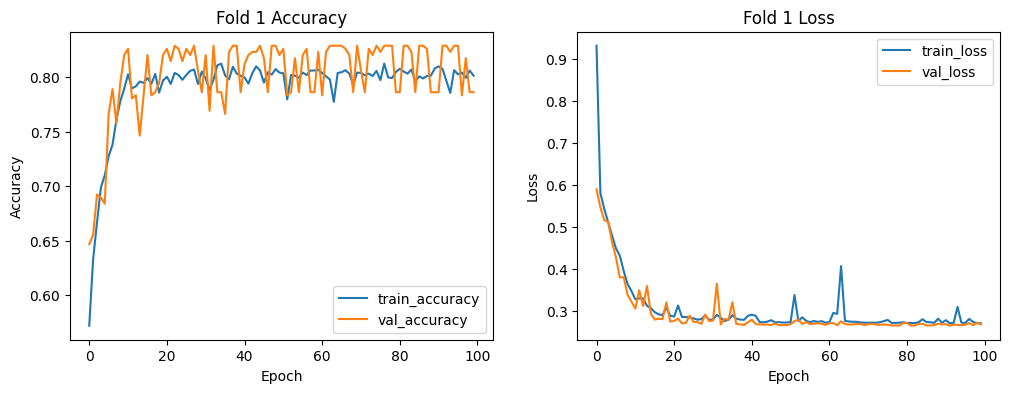

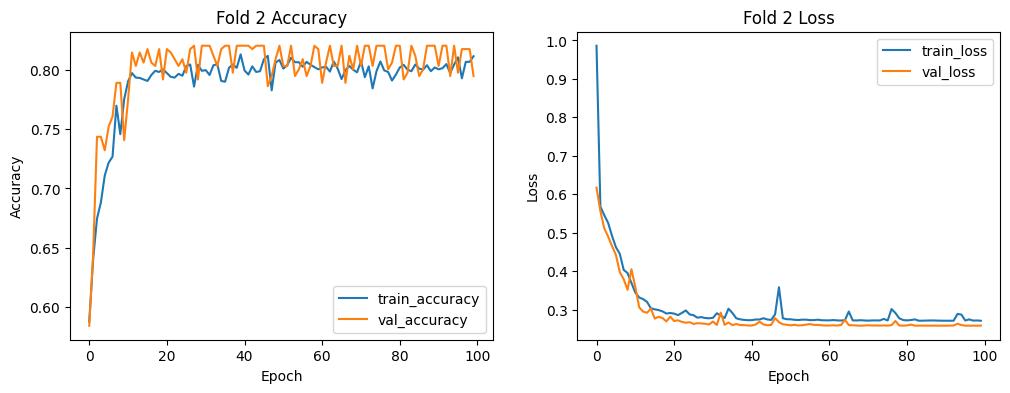

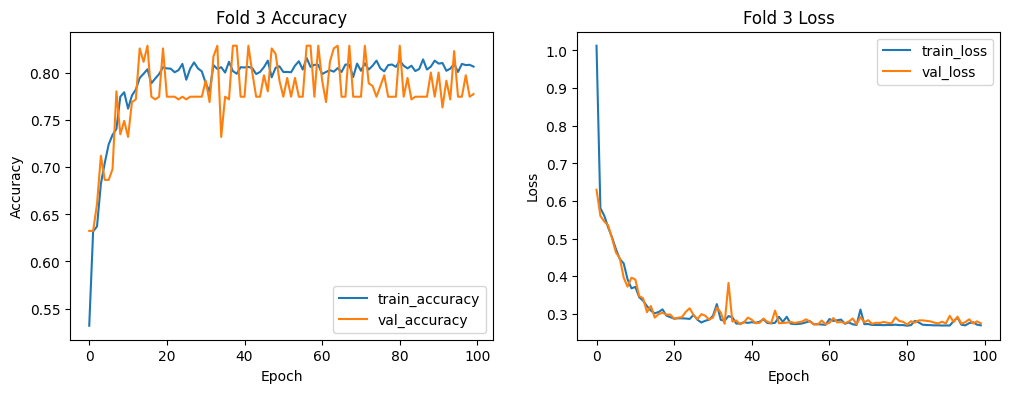

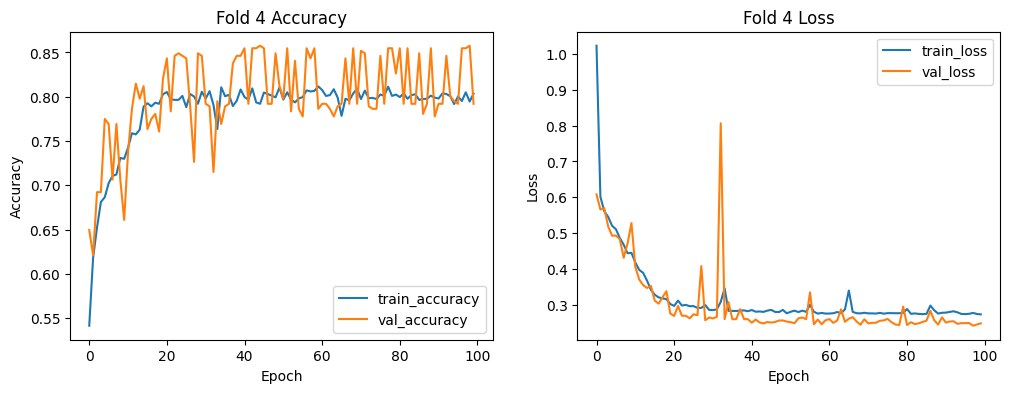

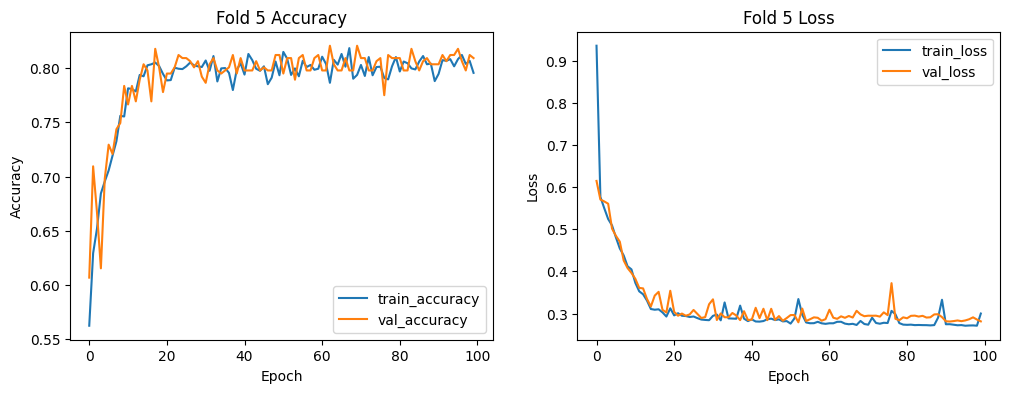

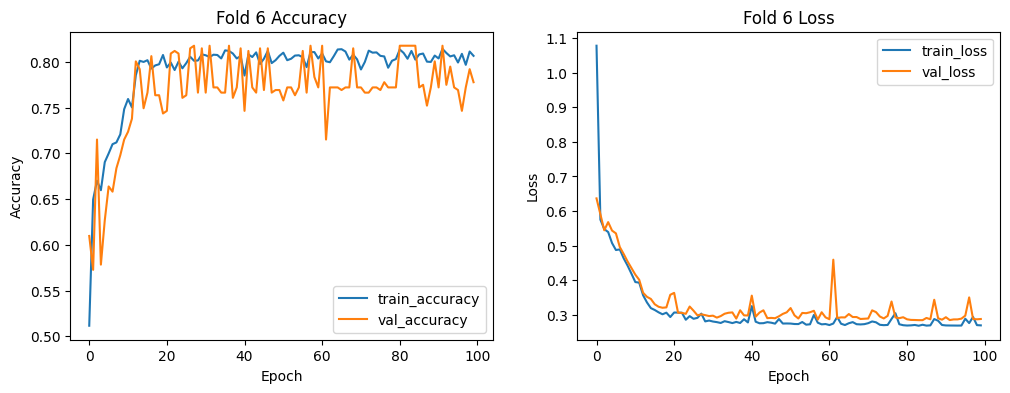

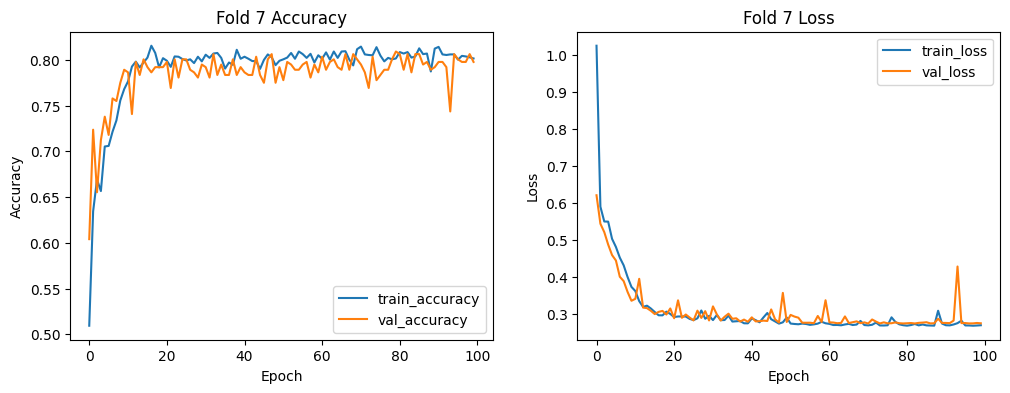

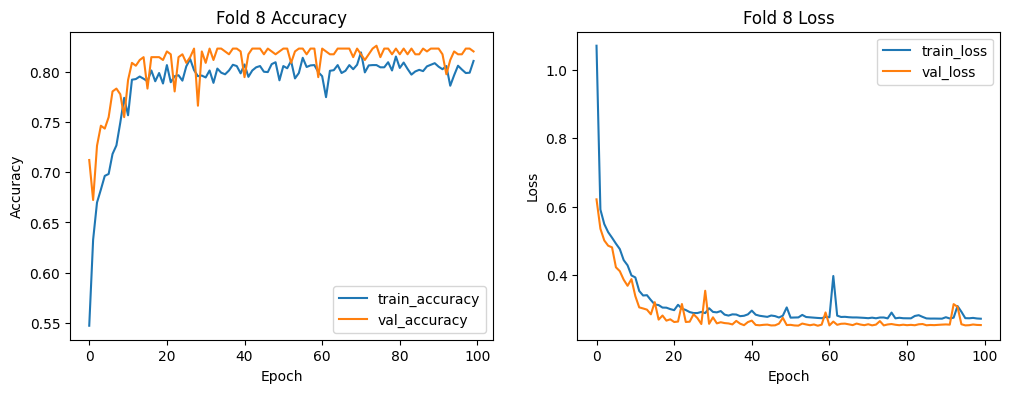

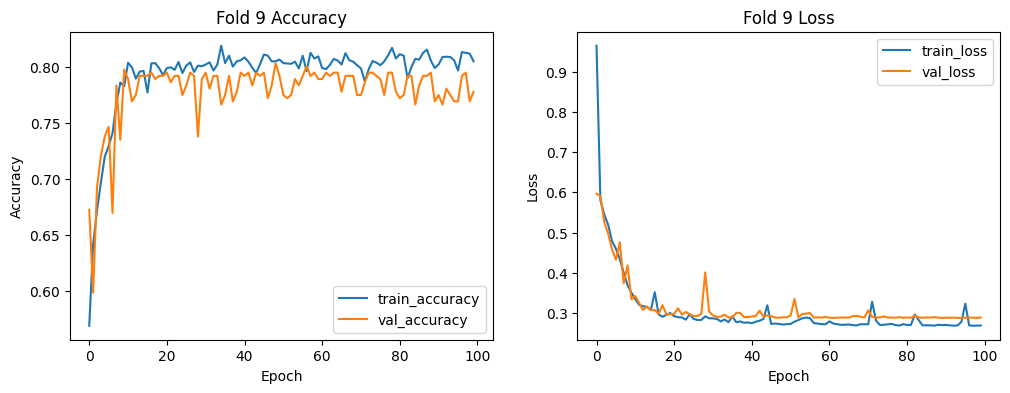

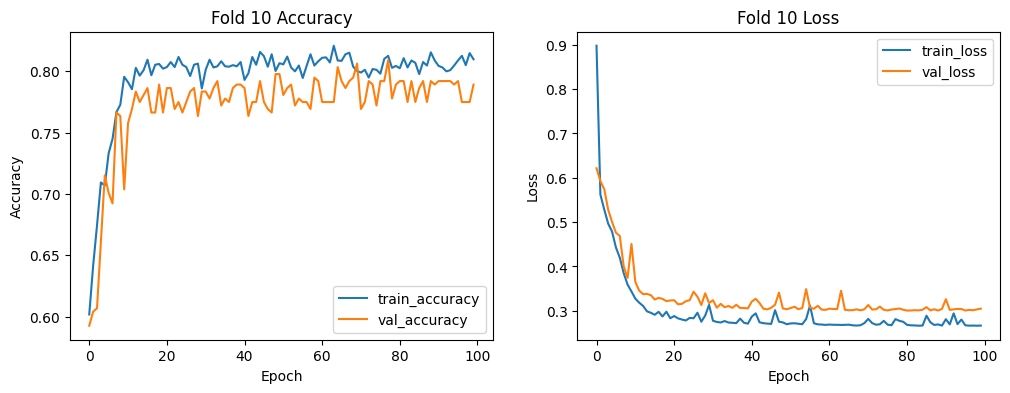

In [8]:
# Plot the results for each fold
for i, history in enumerate(history_list):
    # Accuracy plot
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='train_accuracy')
    plt.plot(history.history['val_accuracy'], label='val_accuracy')
    plt.title(f'Fold {i + 1} Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    # Loss plot
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='train_loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.title(f'Fold {i + 1} Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

`There is no big difference in between train and validation accuracies. So, the model may not overfit.`